In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rtbm.layers as layers
import rtbm.model as mdl

import warnings
warnings.filterwarnings('ignore')

from rtbm.costfunctions import mse
from rtbm import minimizer

from rtbm.mathtools import theta_1d, theta_1d_phaseI
from riemann_theta.riemann_theta import RiemannTheta

import rtbm.layers as layers
import rtbm.model as mdl

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


# Derivatives test

In [2]:
Q=np.zeros((1,1), dtype=complex)
V=np.zeros((1,1), dtype=complex)
V[0,0]=0.1*2j*np.pi
Q[0,0]=0.01*2*np.pi

print(theta_1d(V,Q,0))


print(RiemannTheta(V/(2j*np.pi),1j*Q/(2*np.pi), derivs=[1,1]))

print(RiemannTheta(V/(2j*np.pi),1j*Q/(2*np.pi), derivs=[[1],[1]]))

(0.432139189595-1.9772421444e-16j)
(1434.49605524+5.69872548808e-14j)
(1434.49605524+5.69872548808e-14j)


In [3]:
Q=np.zeros((1,1), dtype=float)
V=np.zeros((1,1), dtype=float)
V[0,0]=0.1
Q[0,0]=0.01


print(theta_1d(V,Q,0))
print(theta_1d_phaseI(V,Q,0))

print(RiemannTheta(V/(2j*np.pi),-1*Q/(2j*np.pi)))

(41.3273135097+0j)
[[41.32731351+0.j]]
(41.3273135097+0j)


In [ ]:
41.0/25.0

# Linear layer test

In [ ]:
def funcA(x):
    return 0.6-0.3*x

def funcB(x):
    return -0.5+0.8*x


def func(x1,x2):
    return 0.6-0.3*x1+1.2*x2

X1 = np.linspace(-5.3, 5, 1000)
X2 = np.linspace(-5.5, 5, 1000)

X = np.stack((X1,X2))

#Y = func(X1,X2).reshape((1,X.shape[1]))
Y = np.stack((funcA(X1),funcB(X2)))

M = mdl.Model()
M.add(layers.Linear(2,2))

#minim = minimizer.CMA(True)
#minim.train(mse(), M, X, Y, tolfun=1e-3)

M = mdl.Model()
M.add(layers.Linear(2,1))
M.add(layers.Linear(1,2))


minim = minimizer.SGD()
minim.train(mse(), M, X, Y, lr=0.0001,maxiter=1000)

# E(h|v) SGD test

(0, ' cost: ', (3.3787023838359915+0j))
(100, ' cost: ', (2.3849628259282305+0j))
(200, ' cost: ', (1.8949450494990328+0j))
(300, ' cost: ', (1.4444664513224197+0j))
(400, ' cost: ', (1.1850970701267585+0j))
(500, ' cost: ', (0.95001231060182845+0j))
(600, ' cost: ', (0.76726161640471102+0j))
(700, ' cost: ', (0.64869573874321262+0j))
(800, ' cost: ', (0.5604777675914816+0j))
(900, ' cost: ', (0.48799635323765017+0j))
(1000, ' cost: ', (0.4307230457422811+0j))
(1100, ' cost: ', (0.3886728204486864+0j))
(1200, ' cost: ', (0.35831541397845068+0j))
(1300, ' cost: ', (0.33576569817945523+0j))
(1400, ' cost: ', (0.31842807225000119+0j))
(1500, ' cost: ', (0.3047491945323535+0j))
(1600, ' cost: ', (0.29380838406547244+0j))
(1700, ' cost: ', (0.28504833837791194+0j))
(1800, ' cost: ', (0.27810248776194413+0j))
(1900, ' cost: ', (0.27268449133902301+0j))
('Cost: ', (0.2685688877088579+0j))
('Sol: ', array([-0.67225882+0.j, -6.92878260+0.j,  7.79877714+0.j]))


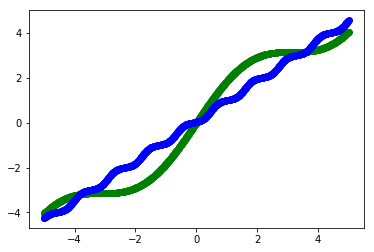

In [4]:
def func(x):
    return np.sin(x)+x

X = np.linspace(-5, 5, 1000)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None]).reshape((1,X.shape[1]))

M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,1))

minim = minimizer.SGD()
minim.train(mse(), M, X, Y, lr=0.01,maxiter=2000)

plt.plot(X.flatten(), Y.flatten(),"og-", label='fit')
plt.plot(X.flatten(), np.real(M.predict(X)).flatten(),"ob-", label='fit')

In [ ]:
def func(x1,x2):
    return 0.2*x1+0.4*x2+0.8

X1 = np.linspace(-5.3, 5, 1000)
X2 = np.linspace(-5.5, 5, 1000)

X = np.stack((X1,X2))

Y = func(X1[:,None],X2[:,None]).reshape((1,X1.shape[0]))

M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(2,1))
M.add(layers.DiagExpectationUnitLayer(1,1))


minim = minimizer.SGD()
minim.train(mse(), M, X, Y, lr=0.1,maxiter=400)

#plt.plot(X.flatten(), Y.flatten(),"og-", label='fit')
#plt.plot(X.flatten(), np.real(M.predict(X)).flatten(),"ob-", label='fit')

# Layer test

In [ ]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,1))

In [ ]:
def func(x):
    return np.sin(x)

X = np.linspace(0, 10, 5)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None]).reshape((1,X.shape[1]))

In [ ]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [ ]:
minim = minimizer.CMA(True)
minim.train(mse(), M, X, Y, tolfun=1e-3)

In [ ]:
npoints = 5
test_X = (np.linspace(0, 10, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.legend()

# Misc tests

In [ ]:
L = layers.MaxPosLayer(3,1)

In [ ]:
L.feedin(np.array([Y,2*Y,1*Y]).reshape(3,5))

In [ ]:
np.array([Y,2*Y,Y]).reshape(3,5)

In [ ]:
np.empty(0)

In [ ]:
derivative_1d_theta_phaseI([0.1],[1j],0)